## Preface:
Thanks to Neel Nanda for the overview on this. [video](https://www.youtube.com/watch?v=bOYE6E8JrtU&t=1307s)

Diagram from [Austin Kozlowski](https://github.com/akozlo)


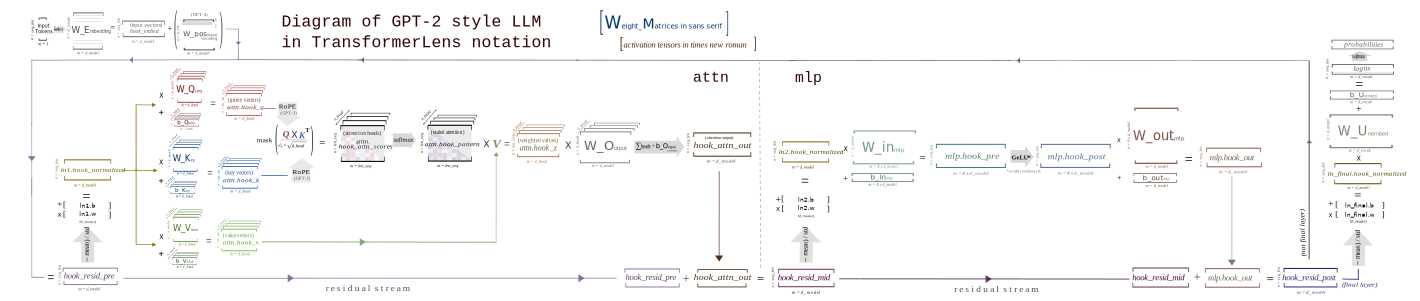

In [30]:
from IPython.display import SVG
display(SVG(filename='/TransformerLens_Diagram.svg'))

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
  %pip install git+https://github.com/neelnanda-io/Easy-Transformer.git@clean-transformer-demo
  # Install another version of node that makes PySvelte work way faster
  !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
  %pip install git+https://github.com/neelnanda-io/PySvelte.git
  %pip install fancy_einsum
  %pip install einops
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/Easy-Transformer.git (to revision clean-transformer-demo) to /tmp/pip-req-build-tanus807
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/Easy-Transformer.git /tmp/pip-req-build-tanus807
  Running command git checkout -b clean-transformer-demo --track origin/clean-transformer-demo
  Switched to a new branch 'clean-transformer-demo'
  Branch 'clean-transformer-demo' set up to track remote branch 'clean-transformer-demo' from 'origin'.
  Resolved https://github.com/neelnanda-io/Easy-Transformer.git to commit 1f25219e631aeb478d17075d47274db32c874e88
  Preparing metadata (setup.py) ... done
  Created wheel for easy_transformer: filename=easy_transformer-0.1.0-py3-none-any.whl size=55601 sha256=2ee89e465f4054393826863c92d86d0c138390195d27215553b41354ae4a3c35
  Stored in directory: /tmp/pip-ephem-wheel-cache-f7at28i0/wheels/93/f3/71/f103ceb7ff1dea0b7c7d213d85708cfeb9bd35e10f18542b19
Su

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import einops
from fancy_einsum import einsum
from dataclasses import dataclass
from easy_transformer import EasyTransformer
import torch
import torch.nn as nn
import numpy as np
import math
from easy_transformer.utils import get_corner, gelu_new, tokenize_and_concatenate
import tqdm.auto as tqdm

In [ ]:
reference_gpt2 = EasyTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Moving model to device:  cuda
Finished loading pretrained model gpt2-small into EasyTransformer!


In [ ]:
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12


In [ ]:
def rand_float_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).cuda()
    random_input = torch.randn(shape).cuda()
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    print("Output shape:", output.shape)
    return output

def rand_int_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).cuda()
    random_input = torch.randint(100, 1000, shape).cuda()
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    print("Output shape:", output.shape)
    return output


In [ ]:
def load_gpt2_test(cls, gpt2_layer, input_name, cache_dict):
    cfg = Config(debug=True)
    layer = cls(cfg).cuda()
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    if isinstance(input_name, str):
        reference_input = cache_dict[input_name]
    else:
        reference_input = input_name
    print("Input shape:", reference_input.shape)
    output = layer(reference_input)
    print("Output shape:", output.shape)
    reference_output = gpt2_layer(reference_input)
    print("Reference output shape:", reference_output.shape)

    comparison = torch.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct")
    return output

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.d_model))
        self.b = nn.Parameter(torch.zeros(cfg.d_model))

    def forward(self, residual):
        residual = residual - einops.reduce(residual, "batch position d_model -> batch position 1", "mean")
        scale = (einops.reduce(residual.pow(2), "batch position d_model -> batch position 1", "mean") + self.cfg.layer_norm_eps).sqrt()
        norm = residual / scale
        norm = norm * self.w + self.b
        if self.cfg.debug:
            print('Normalized:', norm.shape)
        return norm


class Embed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(torch.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, tokens):
        if self.cfg.debug:
            print('tokens:', tokens.shape)
        embed = self.W_E[tokens, :]
        if self.cfg.debug:
            print('embed:', embed.shape)
        return embed


class PosEmbed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(torch.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, tokens):
        batch, seq_len = tokens.shape
        pos_embed = self.W_pos[:seq_len, :]
        pos_embed = einops.repeat(pos_embed, "position d_model -> batch position d_model", batch=batch)
        if self.cfg.debug:
            print('pos_embed:', pos_embed.shape)
        return pos_embed


class Attention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))
        self.W_O = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))
        self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32, device='cuda'))

    def forward(self, normalized_resid_pre):
        q = einsum("batch query_pos d_model, n_heads d_model d_head -> batch query_pos n_heads d_head", normalized_resid_pre, self.W_Q) + self.b_Q
        k = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head", normalized_resid_pre, self.W_K) + self.b_K
        attention_scores = einsum("batch query_pos n_heads d_head, batch key_pos n_heads d_head -> batch n_heads query_pos key_pos", q, k)
        attention_scores = attention_scores / math.sqrt(self.cfg.d_head)
        attention_scores = self.apply_causal_mask(attention_scores)
        pattern = attention_scores.softmax(dim=-1)
        v = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head", normalized_resid_pre, self.W_V) + self.b_V
        z = einsum("batch n_heads query_pos key_pos, batch key_pos n_heads d_head -> batch query_pos n_heads d_head", pattern, v)
        output = einsum("batch query_pos n_heads d_head, n_heads d_head d_model -> batch query_pos d_model", z, self.W_O) + self.b_O
        if self.cfg.debug:
            print('attn output:', output.shape)
        return output

    def apply_causal_mask(self, attention_scores):
        mask = torch.triu(torch.ones(attention_scores.size(-2), attention_scores.size(-1), device=attention_scores.device), diagonal=1).bool()
        attention_scores.masked_fill_(mask, self.IGNORE)
        return attention_scores


class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(torch.empty((cfg.d_model, cfg.d_mlp)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        self.b_in = nn.Parameter(torch.zeros((cfg.d_mlp)))
        self.W_out = nn.Parameter(torch.empty((cfg.d_mlp, cfg.d_model)))
        nn.init.normal_(self.W_out, std=self.cfg.init_range)
        self.b_out = nn.Parameter(torch.zeros((cfg.d_model)))

    def forward(self, normalized_resid_mid):
        pre = einsum("batch position d_model, d_model d_mlp -> batch position d_mlp", normalized_resid_mid, self.W_in) + self.b_in
        post = gelu_new(pre)
        mlp_out = einsum("batch position d_mlp, d_mlp d_model -> batch position d_model", post, self.W_out) + self.b_out
        if self.cfg.debug:
            print('mlp_out:', mlp_out.shape)
        return mlp_out


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(self, resid_pre):
        normalized_resid_pre = self.ln1(resid_pre)
        attn_out = self.attn(normalized_resid_pre)
        resid_mid = resid_pre + attn_out
        normalized_resid_mid = self.ln2(resid_mid)
        mlp_out = self.mlp(normalized_resid_mid)
        resid_post = resid_mid + mlp_out
        if self.cfg.debug:
            print('resid_post:', resid_post.shape)
        return resid_post


class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(torch.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(torch.zeros((cfg.d_vocab), requires_grad=False))

    def forward(self, normalized_resid_final):
        logits = einsum("batch position d_model, d_model d_vocab -> batch position d_vocab", normalized_resid_final, self.W_U) + self.b_U
        if self.cfg.debug:
            print('logits:', logits.shape)
        return logits

Attention pattern visualization

In [24]:
import pysvelte
tokens = tokens.cuda()
logits, cache = reference_gpt2.run_with_cache(tokens)
reference_text = "I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!"
pysvelte.AttentionMulti(tokens=reference_gpt2.to_str_tokens(reference_text), attention=cache['blocks.3.attn.hook_attn'][0].permute(1, 2, 0)).show() # permute (h,q,k) -> (q,k,h)

understanding these features:

- diagonal patterns for causal attention which makes sense.

- Concentration and Dispersion -> specific important tokens and uniformity of attention across a sequence.

- Horizontal lines: tokens that are heavily attended to. pattern 0, 9 and 11



In [ ]:
class DemoTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, tokens):
        embed = self.embed(tokens)
        pos_embed = self.pos_embed(tokens)
        residual = embed + pos_embed
        if self.cfg.debug:
            print('Initial residual:', residual.shape)
        for i, block in enumerate(self.blocks):
            if self.cfg.debug:
                print(f'\n--- Block {i} ---')
            residual = block(residual)
        normalized_resid_final = self.ln_final(residual)
        logits = self.unembed(normalized_resid_final)
        return logits


In [ ]:
cfg = Config(debug=True)
model = DemoTransformer(cfg).cuda()

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

batch_size = 2
seq_len = 35
tokens = torch.randint(0, cfg.d_vocab, (batch_size, seq_len)).cuda()

with torch.no_grad():
    logits = model(tokens)

print("Output logits shape:", logits.shape)


Total parameters: 163,087,441
tokens: torch.Size([2, 35])
embed: torch.Size([2, 35, 768])
pos_embed: torch.Size([2, 35, 768])
Initial residual: torch.Size([2, 35, 768])

--- Block 0 ---
Normalized: torch.Size([2, 35, 768])
attn output: torch.Size([2, 35, 768])
Normalized: torch.Size([2, 35, 768])
mlp_out: torch.Size([2, 35, 768])
resid_post: torch.Size([2, 35, 768])

--- Block 1 ---
Normalized: torch.Size([2, 35, 768])
attn output: torch.Size([2, 35, 768])
Normalized: torch.Size([2, 35, 768])
mlp_out: torch.Size([2, 35, 768])
resid_post: torch.Size([2, 35, 768])

--- Block 2 ---
Normalized: torch.Size([2, 35, 768])
attn output: torch.Size([2, 35, 768])
Normalized: torch.Size([2, 35, 768])
mlp_out: torch.Size([2, 35, 768])
resid_post: torch.Size([2, 35, 768])

--- Block 3 ---
Normalized: torch.Size([2, 35, 768])
attn output: torch.Size([2, 35, 768])
Normalized: torch.Size([2, 35, 768])
mlp_out: torch.Size([2, 35, 768])
resid_post: torch.Size([2, 35, 768])

--- Block 4 ---
Normalized: to

In [ ]:
cfg_test = Config(debug=False)
model_test = DemoTransformer(cfg_test).cuda()

test_seq_len = 50
test_tokens = torch.randint(0, cfg.d_vocab, (1, test_seq_len)).cuda()

with torch.no_grad():
    test_logits = model_test(test_tokens)

print("Output shape:", test_logits.shape)


Output shape: torch.Size([1, 50, 50257])


## Testing model

In [12]:
demo_gpt2 = DemoTransformer(Config(debug=False))
demo_gpt2.load_state_dict(reference_gpt2.state_dict(), strict=False)
demo_gpt2.cuda()

DemoTransformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
  )
  (ln_final): LayerNorm()
  (unembed): Unembed()
)

In [14]:
test_string = "Nizaa is an endangered Mambiloid language spoken in the Adamawa Region of northern Cameroon. Most of the language's speakers live in and around the village of Galim in the department of Faro-et-Déo. Nizaa has a complex sound system with 60 consonant phonemes, eleven tones, and a contrast between oral and nasal vowels. In terms of grammar, it is the only Bantoid language that allows multiple verbal suffixes on one verb. It also is neither a head-initial nor head-final language (the head or main element of a clause appears both before and after its modifiers with roughly equal frequency). Nizaa was first extensively documented in the 1980s by Norwegian linguists Rolf Theil Endresen (pictured) and Bjørghild Kjelsvik. The language is endangered, but the exact number of active speakers is unknown, as the last census of speakers took place in 1985, and a 1983 survey reported drastically different figures."

In [15]:
test_tokens = reference_gpt2.to_tokens(test_string).cuda()
demo_logits = demo_gpt2(test_tokens)

In [16]:
def lm_cross_entropy_loss(logits, tokens):
    # Measure next token loss
    # Logits have shape [batch, position, d_vocab]
    # Tokens have shape [batch, position]
    log_probs = logits.log_softmax(dim=-1)
    pred_log_probs = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    return -pred_log_probs.mean()
loss = lm_cross_entropy_loss(demo_logits, test_tokens)
print(loss)
print("Loss as average prob", (-loss).exp())
print("Loss as 'uniform over this many variables'", (loss).exp())
print("Uniform loss over the vocab", math.log(demo_gpt2.cfg.d_vocab))

tensor(3.7249, device='cuda:0', grad_fn=<NegBackward0>)
Loss as average prob tensor(0.0241, device='cuda:0', grad_fn=<ExpBackward0>)
Loss as 'uniform over this many variables' tensor(41.4672, device='cuda:0', grad_fn=<ExpBackward0>)
Uniform loss over the vocab 10.82490511970208


# Trainning

In [17]:
if IN_COLAB:
    %pip install datasets
    %pip install transformers
import datasets
import transformers
import plotly.express as px

model config

In [18]:
batch_size = 8
num_epochs = 1
max_steps = 1000
log_every = 10
lr = 1e-3
weight_decay = 1e-2
model_cfg = Config(debug=False, d_model=256, n_heads=4, d_head=64, d_mlp=1024, n_layers=2, n_ctx=256, d_vocab=reference_gpt2.cfg.d_vocab)


In [19]:
dataset = datasets.load_dataset("NeelNanda/pile-10k", split="train")
print(dataset)
print(dataset[0]['text'][:100])
tokens_dataset = tokenize_and_concatenate(dataset, reference_gpt2.tokenizer, streaming=False, max_length=model_cfg.n_ctx, column_name="text", add_bos_token=True, num_proc=4)
data_loader = torch.utils.data.DataLoader(tokens_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


README.md:   0%|          | 0.00/373 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

data/train-00000-of-00001-4746b8785c874c(…):   0%|          | 0.00/33.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'meta'],
    num_rows: 10000
})
It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playi


Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (80023 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (101051 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (155995 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (229134 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going 

In [25]:
model = DemoTransformer(model_cfg)
model.cuda()


DemoTransformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
  )
  (ln_final): LayerNorm()
  (unembed): Unembed()
)

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [27]:
losses = []
print("Number of batches:", len(data_loader))
for epoch in range(num_epochs):
    for c, batch in tqdm.tqdm(enumerate(data_loader)):
        tokens = batch['tokens'].cuda()
        logits = model(tokens)
        loss = lm_cross_entropy_loss(logits, tokens)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if c % log_every == 0:
            print(f"Step: {c}, Loss: {loss.item():.4f}")
        if c > max_steps:
            break

Number of batches: 8506


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


0it [00:00, ?it/s]

Step: 0, Loss: 10.8964
Step: 10, Loss: 8.3169
Step: 20, Loss: 8.1758
Step: 30, Loss: 8.2656
Step: 40, Loss: 5.8194
Step: 50, Loss: 7.3404
Step: 60, Loss: 5.7986
Step: 70, Loss: 7.0420
Step: 80, Loss: 7.4592
Step: 90, Loss: 6.7581
Step: 100, Loss: 7.5024
Step: 110, Loss: 7.5971
Step: 120, Loss: 7.4037
Step: 130, Loss: 6.6427
Step: 140, Loss: 7.0466
Step: 150, Loss: 6.1483
Step: 160, Loss: 5.6898
Step: 170, Loss: 7.5150
Step: 180, Loss: 5.8386
Step: 190, Loss: 7.0940
Step: 200, Loss: 6.8353
Step: 210, Loss: 7.2244
Step: 220, Loss: 7.0440
Step: 230, Loss: 6.0029
Step: 240, Loss: 6.7085
Step: 250, Loss: 6.1977
Step: 260, Loss: 7.5184
Step: 270, Loss: 5.4298
Step: 280, Loss: 6.6598
Step: 290, Loss: 7.0715
Step: 300, Loss: 6.4075
Step: 310, Loss: 6.0851
Step: 320, Loss: 6.8420
Step: 330, Loss: 7.0360
Step: 340, Loss: 6.6736
Step: 350, Loss: 6.2173
Step: 360, Loss: 5.6863
Step: 370, Loss: 5.3630
Step: 380, Loss: 5.6127
Step: 390, Loss: 6.6498
Step: 400, Loss: 6.2196
Step: 410, Loss: 5.1938
St

model_cfg.n_ctx * batch_size is mutipliying each step by the total amount of token per loss e.g. loss= 5 is x or tokens = 5 x context_length x batch_size. basically showing the total amount of tokens processed

In [28]:
px.line(y=losses, x=np.arange(len(losses))*(model_cfg.n_ctx * batch_size), labels={"y":"Loss", "x":"Tokens"}, title="Training curve for my tiny demo model!")

Loss starts off high then tailors off to around 5-6. But there are some extreme random spikes in loss when trainning past 1m tokens. Idk maybe some weird gradient updates or simple batch.